# CICY4: A single NN for h11, h21, h31, h22

In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds'
conf = np.load(os.path.join(path, 'conf.npy'))
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [3]:
X = conf
h11 = hodge[:,0]
h21 = hodge[:,1]
h22 = hodge[:,3]
h31 = hodge[:,2]
h11max = np.max(hodge[:,0])
h11min = np.min(hodge[:,0])
print(f'Max h11: {h11max}, Min h11: {h11min} ')
h21max = np.max(hodge[:,1])
h21min = np.min(hodge[:,1])
print(f'Max h21: {h21max}, Min h21: {h21min} ')
h31max = np.max(hodge[:,2])
h31min = np.min(hodge[:,2])
print(f'Max h31: {h31max}, Min h31: {h31min} ')
h22max = np.max(hodge[:,3])
h22min = np.min(hodge[:,3])
print(f'Max h22: {h22max}, Min h22: {h22min} ')

Max h11: 24, Min h11: 0 
Max h21: 33, Min h21: 0 
Max h31: 426, Min h31: 0 
Max h22: 1752, Min h22: 0 


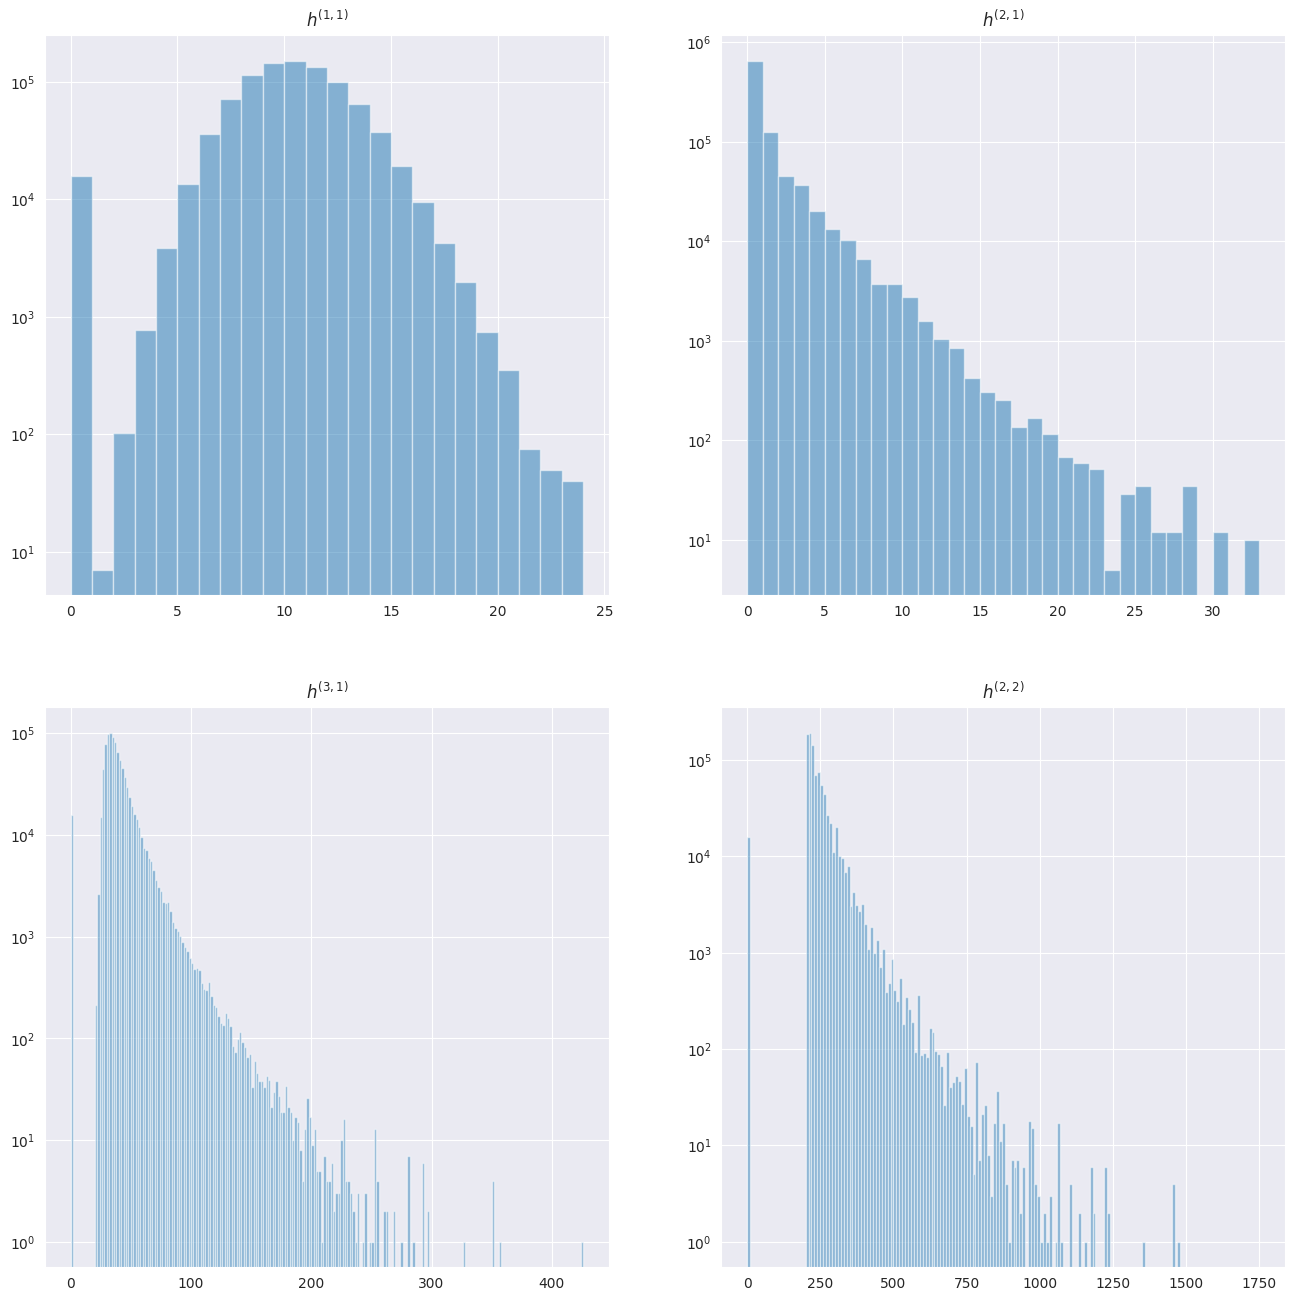

In [4]:
fig, ax = plt.subplots(2,2, figsize = (16,16))
ax[0,0].hist(hodge[:,0], bins=range(h11min, h11max+1), alpha=0.5)
ax[0,0].set_title('$h^{(1,1)}$')
#ax[0,0].ylabel('count')
ax[0,0].set_yscale('log')

ax[0,1].hist(hodge[:,1], bins=range(h21min, h21max+1), alpha=0.5)
ax[0,1].set_title('$h^{(2,1)}$')
#ax[0,0].ylabel('count')
ax[0,1].set_yscale('log')

ax[1,0].hist(hodge[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5)
ax[1,0].set_title('$h^{(3,1)}$')
#ax[0,0].ylabel('count')
ax[1,0].set_yscale('log')

ax[1,1].hist(hodge[:,3], bins=range(h22min, h22max+1,10), alpha=0.5)
ax[1,1].set_title('$h^{(2,2)}$')
#ax[0,0].ylabel('count')
ax[1,1].set_yscale('log')

# Import predefined functions and prepare data

In [5]:
import sys
sys.path.append('/kaggle/input/calabi-yau-cicy-4-folds')
from CICY4_functions import data_generator, batch_gd,  calc_accuracy

In [6]:
from sklearn.model_selection import train_test_split

def train_test(X, y):
    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)
    
    X_train = torch.from_numpy(X_train.astype(np.float32))
    #only need reshape if the y dimension is 1
    #y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    X_test = torch.from_numpy(X_test.astype(np.float32))
    #y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))
    y_test = torch.from_numpy(y_test.astype(np.float32))                         
    
    print(f'X_train shape: {X_train.shape}, \n y_train shape:{y_train.shape},\
                 \n X_test shape: {X_test.shape}, \n y_test shape:{y_test.shape}')
    return X_train, X_test, y_train, y_test

In [7]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
y = np.zeros((921497,4))
y[:,0] = h11
y[:,1] = h21
y[:,2] = h31
y[:,3] = h22

In [10]:
y.shape, np.array_equal(y[:,0],h11)

((921497, 4), True)

In [11]:
X_train, X_test, y_train, y_test = train_test(X, y)

X_train shape: torch.Size([737197, 16, 20]), 
 y_train shape:torch.Size([737197, 4]),                 
 X_test shape: torch.Size([184300, 16, 20]), 
 y_test shape:torch.Size([184300, 4])


In [12]:
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

In [13]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.show()

In [14]:
################## ACCURACY CALCULATION #####################
def calc_accuracy_mr(model, train_gen, test_gen, device, cnn = False):
    model.eval()
    n_correct_h11 = 0.
    n_total_h11 = 0.
    n_correct_h21 = 0.
    n_total_h21 = 0.
    n_correct_h31 = 0.
    n_total_h31 = 0.
    n_correct_h22 = 0.
    n_total_h22 = 0.
    
    batch_size =128
    
    for inputs, target in train_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        #Perform the prediction
        #round up the prediction to the nearest integer
        ypred = torch.round(model(inputs))
        yp_h11 = ypred[:,0]
        yp_h21 = ypred[:,1]
        yp_h31 = ypred[:,2]
        yp_h22 = ypred[:,3]
        tg_h11 = target[:,0]
        tg_h21 = target[:,1]
        tg_h31 = target[:,2]
        tg_h22 = target[:,3]
        # update counts
        n_correct_h11 += (yp_h11 == tg_h11).sum().item()
        n_total_h11 += tg_h11.shape[0]
        n_correct_h21 += (yp_h21 == tg_h21).sum().item()
        n_total_h21 += tg_h21.shape[0]
        n_correct_h31 += (yp_h31 == tg_h31).sum().item()
        n_total_h31 += tg_h31.shape[0]
        n_correct_h22 += (yp_h22 == tg_h22).sum().item()
        n_total_h22 += tg_h22.shape[0]
    train_acc_h11 = n_correct_h11 / n_total_h11
    train_acc_h21 = n_correct_h21 / n_total_h21
    train_acc_h31 = n_correct_h31 / n_total_h31
    train_acc_h22 = n_correct_h22 / n_total_h22
    
    #TEST SET
    n_correct_h11 = 0.
    n_total_h11 = 0.
    n_correct_h21 = 0.
    n_total_h21 = 0.
    n_correct_h31 = 0.
    n_total_h31 = 0.
    n_correct_h22 = 0.
    n_total_h22 = 0.
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        
        # Forward pass
        ypred = torch.round(model(inputs))
        yp_h11 = ypred[:,0]
        yp_h21 = ypred[:,1]
        yp_h31 = ypred[:,2]
        yp_h22 = ypred[:,3]
        tg_h11 = target[:,0]
        tg_h21 = target[:,1]
        tg_h31 = target[:,2]
        tg_h22 = target[:,3]
        # update counts
        n_correct_h11 += (yp_h11 == tg_h11).sum().item()
        n_total_h11 += tg_h11.shape[0]
        n_correct_h21 += (yp_h21 == tg_h21).sum().item()
        n_total_h21 += tg_h21.shape[0]
        n_correct_h31 += (yp_h31 == tg_h31).sum().item()
        n_total_h31 += tg_h31.shape[0]
        n_correct_h22 += (yp_h22 == tg_h22).sum().item()
        n_total_h22 += tg_h22.shape[0]
    test_acc_h11 = n_correct_h11 / n_total_h11
    test_acc_h21 = n_correct_h21 / n_total_h21
    test_acc_h31 = n_correct_h31 / n_total_h31
    test_acc_h22 = n_correct_h22 / n_total_h22
    
    train_acc = [train_acc_h11,train_acc_h21,train_acc_h31,train_acc_h22]
    test_acc = [test_acc_h11,test_acc_h21,test_acc_h31,test_acc_h22]

    return train_acc, test_acc

# CNN model

In [15]:
##################### CNN ###############################
class CNN_cicy4(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        #self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128,64, 3, 1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            #self.bn1,
            self.mxpool,
            #self.bn2,
            self.conv2,
            self.mxpool,
        )
        self.linear1 = nn.Linear(384,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,128)
        self.linear4 = nn.Linear(128,4)


    def forward(self,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        
        return x

In [16]:
model = CNN_cicy4()
model.to(device)

CNN_cicy4(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=384, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=4, bias=True)
)

In [17]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

    2048
     128
   73728
      64
  393216
    1024
  524288
     512
   65536
     128
     512
       4
________
 1061188


In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

## Shape Tracing

In [19]:
X = X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')

X = model.conv_total(X)
print(f'Original shape of the image after passing through {model.conv_total}: \n {X.shape}\n')

X = model.flat(X)
print(f'Original shape of the image after passing through {model.flat}: \n {X.shape}\n')

X = model.linear1(X)
print(f'Shape of the image after passing through the {model.linear1}: \n {X.shape}\n')

X = model.linear2(X)
print(f'Shape of the image after passing through the {model.linear2}: \n {X.shape}\n')

X = model.linear3(X)
print(f'Shape of the image after passing through the {model.linear3}: \n {X.shape}\n')

X = model.linear4(X)
print(f'Shape of the image after passing through the {model.linear4}: \n {X.shape}\n')
 
print(X)

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Original shape of the image after passing through Sequential(
  (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
): 
 torch.Size([1, 64, 2, 3])

Original shape of the image after passing through Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 384])

Shape of the image after passing through the Linear(in_features=384, out_features=1024, bias=True): 
 torch.Size([1, 1024])

Shape of the image after passing through the Linear(in_features=1024, out_features=512, bias=True): 
 torch.Size([1, 512])

Shape of the image after passing through the Linear(in_features=512, out_features=128

In [20]:
#PRINT OUT SOME OUTPUTS TO COMPARE BETWEEN PREDICTIONS AND TARGETS
for inputs, target in train_gen():
    inputs = inputs.view(-1,1,16,20)
    inputs, target = inputs.to(device), target.to(device)
    #Perform the prediction
    #ypred = torch.round(model(inputs))
    ypred = (model(inputs))
    print(f'Target shape: {target.shape}, \n Target[1]: {target[:1]}\n')
    print(f'Prediction shape: {ypred.shape},\n Prediction[1]:{ypred[:1]}\n')

    MAE = nn.L1Loss()
    MSE = nn.MSELoss()
    loss = MAE(ypred[:1], target[:1])
    print(f'MAE Loss: {loss}')
    loss2 = MSE(ypred[:1], target[:1])
    print(f'MSE Loss: {loss2}')
    break

Target shape: torch.Size([128, 4]), 
 Target[1]: tensor([[  9.,   0.,  45., 260.]], device='cuda:0')

Prediction shape: torch.Size([128, 4]),
 Prediction[1]:tensor([[ 0.0828,  0.0027, -0.0245, -0.0285]], device='cuda:0',
       grad_fn=<SliceBackward0>)

MAE Loss: 78.49324798583984
MSE Loss: 17430.38671875


# Train loop

In [21]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, train_gen, test_gen, 150, device, 128, cnn=True)

Epoch: 1/150, train loss:  652.4858          test_loss:  374.3220, duration: 0:00:18.559683
Epoch: 2/150, train loss:  282.8992          test_loss:  222.9656, duration: 0:00:18.458235
Epoch: 3/150, train loss:  193.9893          test_loss:  171.8244, duration: 0:00:18.455704
Epoch: 4/150, train loss:  152.5853          test_loss:  131.6269, duration: 0:00:18.306806
Epoch: 5/150, train loss:  127.3305          test_loss:  130.9459, duration: 0:00:18.336146
Epoch: 6/150, train loss:  108.3280          test_loss:  132.1856, duration: 0:00:18.189705
Epoch: 7/150, train loss:  95.8015          test_loss:  92.4593, duration: 0:00:18.252784
Epoch: 8/150, train loss:  88.0251          test_loss:  86.5434, duration: 0:00:18.296817
Epoch: 9/150, train loss:  81.0533          test_loss:  87.5556, duration: 0:00:18.240493
Epoch: 10/150, train loss:  74.8288          test_loss:  74.3254, duration: 0:00:18.298645
Epoch: 11/150, train loss:  71.1745          test_loss:  73.0461, duration: 0:00:18.287

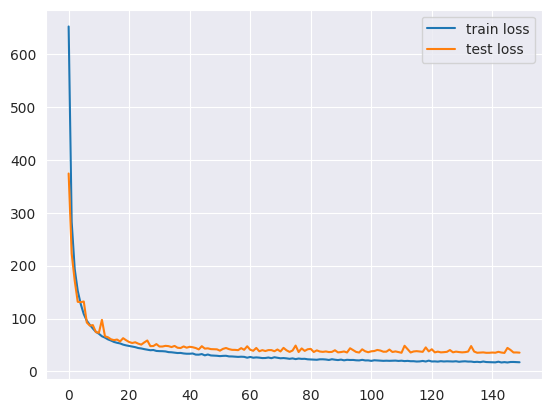

In [22]:
plot_losses(train_losses, test_losses)

##  Calculate accuracy

In [23]:
#PRINT OUT SOME OUTPUTS TO COMPARE BETWEEN PREDICTIONS AND TARGETS
for inputs, target in test_gen():
    inputs = inputs.view(-1,1,16,20)
    inputs, target = inputs.to(device), target.to(device)
    #Perform the prediction
    #ypred = torch.round(model(inputs))
    ypred = torch.round(model(inputs))
    print(f'Target shape: {target.shape}, \n Target[1]: {target[:1]}\n')
    print(f'Prediction shape: {ypred.shape},\n Prediction[1]:{ypred[:1]}\n')
    loss = criterion(ypred[:1], target[:1])
    print(f'Loss: {loss}')
    print(ypred[:1]== target[:1])
    break

Target shape: torch.Size([128, 4]), 
 Target[1]: tensor([[  9.,   3.,  40., 234.]], device='cuda:0')

Prediction shape: torch.Size([128, 4]),
 Prediction[1]:tensor([[ 11.,   2.,  35., 223.]], device='cuda:0', grad_fn=<SliceBackward0>)

Loss: 37.75
tensor([[False, False, False, False]], device='cuda:0')


In [24]:
train_acc, test_acc = calc_accuracy_mr(model, train_gen , test_gen, device = device, cnn= True)


In [25]:
print(f'Train accuracy for h11:{train_acc[0]:.4f}, Test accuracy for h11: {test_acc[0]:.4f}')
print(f'Train accuracy for h21:{train_acc[1]:.4f}, Test accuracy for h21: {test_acc[1]:.4f}')
print(f'Train accuracy for h31:{train_acc[2]:.4f}, Test accuracy for h31: {test_acc[2]:.4f}')
print(f'Train accuracy for h22:{train_acc[3]:.4f}, Test accuracy for h22: {test_acc[3]:.4f}')

Train accuracy for h11:0.5294, Test accuracy for h11: 0.5282
Train accuracy for h21:0.6552, Test accuracy for h21: 0.6491
Train accuracy for h31:0.2300, Test accuracy for h31: 0.2025
Train accuracy for h22:0.0789, Test accuracy for h22: 0.0697


In [26]:
torch.save(model, '/kaggle/working/saved_models/CNN_cicy4_Hodge_bn.pt')

# RNN model with GRU layers

In [27]:
class RNN_cicy4(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_cicy4,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        #self.lstm = nn.LSTM(input_size = self.D,
        #                   hidden_size = self.M,
        #                   num_layers = self.L,
        #                   batch_first = True)    
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.fc1 = nn.Linear(self.M, 128)
        self.fc2 = nn.Linear(128, self.K)
       
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        #out, _ = self.lstm(X, (h0,c0))
        out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        out = out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [28]:
#( n_inputs, n_hidden, n_rnnlayers, n_outputs)
# n_inputs = D = # of columns: 20, T = 16
#input shape is NxTxD: Nx16x20
model = RNN_cicy4(20, 64, 6, 4)
model.to(device)

RNN_cicy4(
  (gru): GRU(20, 64, num_layers=6, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [29]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(sum(params))

150148


In [30]:
X = X_train[0].to(device)
y = y_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
print(f'The new size is {X.shape}\n')

h0 = torch.zeros(model.L, X.size(0), model.M).to(device)
c0 = torch.zeros(model.L, X.size(0), model.M).to(device)
X, _ = model.gru(X, h0)
print(f'Shape of the image after passing through the {model.gru}: \n {X.shape}\n')

X = model.fc1(X[:,-1,:])
print(f'Shape of the image after passing through the {model.fc1}: \n {X.shape}\n')

X = model.fc2(X)
print(f'Shape of the image after passing through the {model.fc2}: \n {X.shape}\n')
 
print(X)
print(f'Target: {y}')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 16, 20])

Shape of the image after passing through the GRU(20, 64, num_layers=6, batch_first=True): 
 torch.Size([1, 16, 64])

Shape of the image after passing through the Linear(in_features=64, out_features=128, bias=True): 
 torch.Size([1, 128])

Shape of the image after passing through the Linear(in_features=128, out_features=4, bias=True): 
 torch.Size([1, 4])

tensor([[ 0.0101, -0.1235, -0.0179, -0.0862]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Target: tensor([ 11.,   0.,  34., 224.], device='cuda:0')


In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [32]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, train_gen, test_gen, 150, device, 128, cnn=False)

Epoch: 1/150, train loss:  1148.1639          test_loss:  904.4354, duration: 0:00:22.425470
Epoch: 2/150, train loss:  906.1910          test_loss:  907.2672, duration: 0:00:21.967393
Epoch: 3/150, train loss:  890.5415          test_loss:  787.0931, duration: 0:00:22.433166
Epoch: 4/150, train loss:  756.0742          test_loss:  738.2674, duration: 0:00:22.257333
Epoch: 5/150, train loss:  591.3076          test_loss:  458.2655, duration: 0:00:22.586755
Epoch: 6/150, train loss:  409.7117          test_loss:  320.5071, duration: 0:00:22.127400
Epoch: 7/150, train loss:  267.6446          test_loss:  252.4029, duration: 0:00:22.508686
Epoch: 8/150, train loss:  194.0517          test_loss:  157.4478, duration: 0:00:22.751808
Epoch: 9/150, train loss:  146.7525          test_loss:  154.5893, duration: 0:00:22.714174
Epoch: 10/150, train loss:  118.4412          test_loss:  117.3239, duration: 0:00:22.542407
Epoch: 11/150, train loss:  91.9647          test_loss:  84.0378, duration: 0:

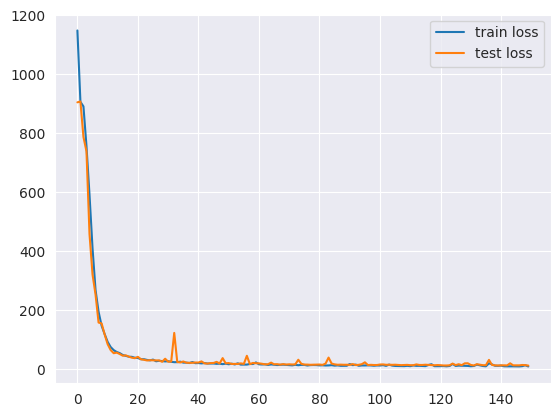

In [33]:
plot_losses(train_losses, test_losses)

In [34]:
train_acc, test_acc = calc_accuracy_mr(model, train_gen , test_gen, device = device, cnn= False)
print(f'Train accuracy for h11:{train_acc[0]:.4f}, Test accuracy for h11: {test_acc[0]:.4f}')
print(f'Train accuracy for h21:{train_acc[1]:.4f}, Test accuracy for h21: {test_acc[1]:.4f}')
print(f'Train accuracy for h31:{train_acc[2]:.4f}, Test accuracy for h31: {test_acc[2]:.4f}')
print(f'Train accuracy for h22:{train_acc[3]:.4f}, Test accuracy for h22: {test_acc[3]:.4f}')

Train accuracy for h11:0.7201, Test accuracy for h11: 0.7196
Train accuracy for h21:0.6842, Test accuracy for h21: 0.6809
Train accuracy for h31:0.3493, Test accuracy for h31: 0.3360
Train accuracy for h22:0.1459, Test accuracy for h22: 0.1415


# ResNet1d-GRU hybrid model

Under experimentation.

In [35]:
class ResNet1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.0, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.maxpool(out)
        identity = self.downsampling(x)
        out += identity
        return out

In [36]:
class ResNet_GRU(nn.Module):

    def __init__(self, kernels, in_channels, fixed_kernel_size,
                 num_outputs,linear_layer_features):
        super(ResNet_GRU, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels
        
        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, 
                                 out_channels=self.planes, 
                                 kernel_size=(kernel_size),
                                 stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)
            
        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, 
                               out_channels=self.planes, 
                               kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, 
                                             stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, 
                          num_layers=1, bidirectional=True)
        self.fc = nn.Linear(in_features=linear_layer_features, 
                            out_features=num_outputs)
###########################################################################  
    def _make_resnet_layer(self, kernel_size, stride, blocks=4, padding=0):
    
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet1D_Block(in_channels=self.planes, 
                                          out_channels=self.planes, 
                                          kernel_size=kernel_size,
                                          stride=stride, padding=padding,
                                          downsampling=downsampling))

        return nn.Sequential(*layers)
  ###########################################################################  
    def extract_features(self, x):
    
        x = x.permute(0, 2, 1)
        out_sep = []
        # CNN ResNet block
        # create parallel convolutions
        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)
        #concatenate the outputs of the parallel convos
        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out) 
        # ResNet1d block
        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  
        out = out.reshape(out.shape[0], -1) 
        #GRU output
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  
        #Concatenate
        new_out = torch.cat([out, new_rnn_h], dim=1) 
        return new_out
     ###########################################################################  
    def forward(self, x):
        new_out = self.extract_features(x)
        result = self.fc(new_out)  

        return result

In [37]:
# Test with dummy input of form NxTxD
import gc
print('----------------------DUMMY VARIABLE FOR TESTING ----------------------')
iot = torch.randn(2, 10000, 8)#.cuda()

model = ResNet_GRU(kernels=[3,5], in_channels=8, 
                   fixed_kernel_size=5, num_outputs=4, linear_layer_features = 2752)
print(model)

print('----------------------SHAPE TRACING----------------------')
#iot = model.bn1(iot)
#print(f'After the {model.bn1} layer, the shape is {iot.shape}')

#iot = model.block(iot)
#print(f'After the ResNet block, the shape is {iot.shape}')

#iot = model.extract_features(iot)
#print(f'After the feature-extraction layer, the shape is {iot.shape}')

output = model(iot)
print(output.shape)

del iot, model
gc.collect()

----------------------DUMMY VARIABLE FOR TESTING ----------------------
ResNet_GRU(
  (parallel_conv): ModuleList(
    (0): Conv1d(8, 24, kernel_size=(3,), stride=(1,), bias=False)
    (1): Conv1d(8, 24, kernel_size=(5,), stride=(1,), bias=False)
  )
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
  (block): Sequential(
    (0): ResNet1D_Block(
      (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.0, inplace=False)
      (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

3935

In [38]:
io1 = torch.randn(2, 10000, 8)
io2 = X_train[0].view(-1, 16,20)
io1.shape, io2.shape

(torch.Size([2, 10000, 8]), torch.Size([1, 16, 20]))

In [39]:
# Test with dummy input of form NxTxD
import gc

iot = X_train[0].view(-1, 16,20)

model = ResNet_GRU(kernels=[4,3], in_channels=20, 
                   fixed_kernel_size=5, num_outputs=4, linear_layer_features = 328)
print(model)
#output = model(iot)
#print(output.shape)

del iot, model
gc.collect()

ResNet_GRU(
  (parallel_conv): ModuleList(
    (0): Conv1d(20, 24, kernel_size=(4,), stride=(1,), bias=False)
    (1): Conv1d(20, 24, kernel_size=(3,), stride=(1,), bias=False)
  )
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
  (block): Sequential(
    (0): ResNet1D_Block(
      (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.0, inplace=False)
      (conv1): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsampling): Sequential(
        (0): MaxPool1d(kerne

0